In [2]:
### Magic functinos
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

In [3]:
### imports
import warnings
warnings.simplefilter('ignore')
import itertools
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mliv.dgps import get_data, get_tau_fn, fn_dict
from mliv.neuralnet.utilities import mean_ci
from mliv.neuralnet import AGMMEarlyStop as AGMM
from mliv.neuralnet.moments import avg_small_diff
from sklearn.ensemble import RandomForestRegressor

## $\ell_2$-Regularized AGMM with Neural Net Test Function

We solve the problem:
\begin{equation}
\min_{\theta} \max_{w} \frac{1}{n} \sum_i (y_i - h_{\theta}(x_i)) f_w(z_i) - f_w(z_i)^2
\end{equation}
where $h_{\theta}$ and $f_w$ are two neural nets.

In [98]:
def exp(it, n, n_z, n_t, iv_strength, fname, dgp_num, moment_fn, special_test=True, lambda_l2_h=0):
    np.random.seed(it)
    
    #####
    # Neural network parameters
    ####
    p = 0.1 # dropout prob of dropout layers throughout notebook
    n_hidden = 100 # width of hidden layers throughout notebook
    learner_lr = 1e-4
    adversary_lr = 1e-4
    learner_l2 = 1e-3
    adversary_l2 = 1e-3
    n_epochs = 2000
    bs = 100
    device = None
    
    ######
    # Train test split
    ######
    Z, T, Y, true_fn = get_data(n, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
    Z_train, Z_val, T_train, T_val, Y_train, Y_val = train_test_split(Z, T, Y, test_size=.5, shuffle=True)
    Z_train, T_train, Y_train = map(lambda x: torch.Tensor(x), (Z_train, T_train, Y_train))
    Z_val, T_val, Y_val = map(lambda x: torch.Tensor(x).to(device), (Z_val, T_val, Y_val))

    
    #####
    # Train "riesz" representer xi
    #####
    learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    adversary_fn = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                                 nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    def logger(learner, adversary, epoch, writer):
        return 
    reisz = AGMM(learner, adversary_fn).fit(Z_train, T_train, Y_train, Z_val, T_val, Y_val,
                                            learner_lr=learner_lr, adversary_lr=adversary_lr,
                                            learner_l2=learner_l2, adversary_l2=adversary_l2,
                                            n_epochs=n_epochs, bs=bs, logger=logger,
                                            model_dir=f'riesz_model_{it}', device=device,
                                            riesz=True, moment_fn=moment_fn, verbose=0,
                                            min_eval_epoch=50)
    
    ######
    # Train "riesz" representer q
    ######
    qfun = RandomForestRegressor(min_samples_leaf=20).fit(Z_train, reisz.predict(T_train).ravel())
    
    ######
    # Train IV function h
    ######

    # Add "clever instrument" to instrument vector
    augZ_val = Z_val
    augZ_train = Z_train
    augT_val = T_val
    augT_train = T_train
    if special_test:
        qtrain = torch.tensor(qfun.predict(Z_train).reshape(-1, 1)).float()
        # .1 is to avoid overshooting in the training of the coefficient during the first
        # few epochs of gradient descent; especially since coefficient is un-penalized
        qtrain = .1 * qtrain / (qtrain**2).mean().sqrt()
        augZ_train = torch.cat([qtrain, Z_train], dim=1)
        qval = torch.tensor(qfun.predict(Z_val).reshape(-1, 1)).float()
        qval = .1 * qval / (qval**2).mean().sqrt()
        augZ_val = torch.cat([qval, Z_val], dim=1)

    adversary_fn = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                                 nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    
    agmm = AGMM(learner, adversary_fn, special_test=special_test)
    agmm.fit(augZ_train, T_train, Y_train, augZ_val, T_val, Y_val,
             learner_lr=learner_lr, adversary_lr=adversary_lr,
             learner_l2=learner_l2, adversary_l2=adversary_l2,
             learner_tikhonov=lambda_l2_h,
             n_epochs=n_epochs, bs=bs, logger=logger,
             model_dir=f'agmm_model_{it}', device=device, verbose=0,
             min_eval_epoch=50)

    
    #####
    # Average moment calculation
    #####
    direct = moment_fn(T_val, agmm.predict, device='cpu').flatten()
    residual = (Y_val - agmm.predict(T_val)).detach().numpy().flatten()
    qvalues = qfun.predict(Z_val).flatten()
    pseudo = direct + qvalues * residual
    dr = mean_ci(pseudo)
    ipw = mean_ci(qvalues * Y_val.detach().numpy().flatten())
    reg = mean_ci(direct)
    
    xivalues = reisz.predict(T_val).flatten()
    coef = np.mean(qvalues * residual) / np.mean(qvalues * xivalues)
    pseudo_tmle = direct + coef * moment_fn(T_val, reisz.predict, device='cpu').flatten()
    pseudo_tmle += qvalues * (residual - coef * xivalues)
    tmle = mean_ci(pseudo_tmle)

    return dr, tmle, ipw, reg

In [99]:
n = 5000
n_z = 1
n_t = 1
iv_strength = .05
fname = 'sigmoid'
dgp_num = 5
epsilon = .1 # average finite difference epsilon
moment_fn = lambda x, fn, device: avg_small_diff(x, fn, device, epsilon)
lambda_l2_h = .1/n**(.9)
clever = True

Z, T, Y, true_fn = get_data(1000000, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
true = np.mean(moment_fn(T, true_fn, device='cpu'))
print(f'True: {true:.4f}')

True: 0.1386


In [100]:
exp(1, n, n_z, n_t, iv_strength, fname, dgp_num, moment_fn, clever, lambda_l2_h)

((0.008576425512052134, -0.05948952680590684, 0.07664237783001111),
 (0.03186673, -0.056343924869689616, 0.12007738338867155),
 (0.8629815888884205, 0.3237488347763755, 1.4022143430004654),
 (0.057288904, 0.057288897134275325, 0.057288910351781956))

In [71]:
%tensorboard --logdir=runs

In [79]:
def plot_results(fname, n, iv_strength, dr, tmle, ipw, direct, true):
    plt.title(f'fname={fname}, n={n}, strength={iv_strength}, true={true:.3f}\n'
              f'dr: Cov={np.mean((dr[:, 1] <= true) & (true <= dr[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((dr[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((dr[:, 0]-true)):.3f}\n'
              f'tmle: Cov={np.mean((tmle[:, 1] <= true) & (true <= tmle[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((tmle[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((tmle[:, 0]-true)):.3f}\n'
              f'ipw: Cov={np.mean((ipw[:, 1] <= true) & (true <= ipw[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((ipw[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((ipw[:, 0]-true)):.3f}\n'
              f'direct: Cov={np.mean((direct[:, 1] <= true) & (true <= direct[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((direct[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((direct[:, 0]-true)):.3f}\n')
    plt.hist(dr[:, 0], label='dr')
    plt.hist(tmle[:, 0], label='tmle', alpha=.4)
    plt.hist(ipw[:, 0], label='ipw', alpha=.4)
    plt.hist(direct[:, 0], label='direct', alpha=.4)
    plt.legend()

True
True: -0.4210


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  2.8min remaining:  8.5min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  3.1min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.6min finished


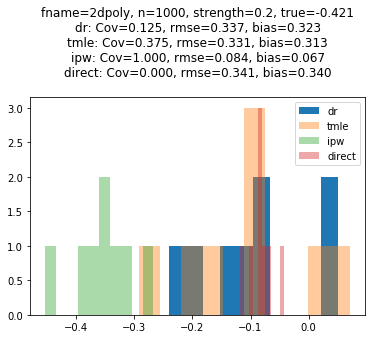

False
True: -0.4217


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  2.4min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  2.9min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.8min finished


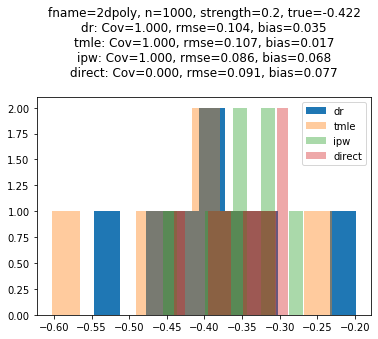

In [80]:
import joblib
from joblib import Parallel, delayed

n_z = 1
n_t = 1
dgp_num = 5
epsilon = 0.1 # average finite difference epsilon
moment_fn = lambda x, fn, device: avg_small_diff(x, fn, device, epsilon)

for clever in [True, False]:
    print(clever)
    for fname in ['2dpoly']:
        for n in [1000]:
            for iv_strength in [.2]:
                lambda_l2_h = .1/n**(.9)
                Z, T, Y, true_fn = get_data(1000000, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
                true = np.mean(moment_fn(T, true_fn, device='cpu'))
                print(f'True: {true:.4f}')
                results = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, n_z, n_t, iv_strength,
                                                                      fname, dgp_num, moment_fn,
                                                                      special_test=clever, lambda_l2_h=lambda_l2_h)
                                                         for it in range(8))
                dr = np.array([r[0] for r in results])
                tmle = np.array([r[1] for r in results])
                ipw = np.array([r[2] for r in results])
                direct = np.array([r[3] for r in results])
                plot_results(fname, n, iv_strength, dr, tmle, ipw, direct, true)
                plt.show()

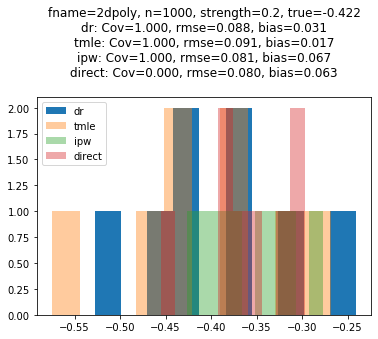

In [38]:
plot_results(fname, n, iv_strength, dr, tmle, ipw, direct, true)
plt.show()